## classificação de compostos químicos 

Objetivo : classificação de compostos químicos baseada na sua capacidade de interagir com a proteína p53 (elemento importante na prevenção do desenvolvimento de tumores)

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

In [71]:
ds = pd.read_csv('tox21.csv')



1. Data Pre-processing

In [72]:
ds.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


In [73]:
ds.shape

(7831, 14)

In [74]:
ds.isnull().sum()

NR-AR             566
NR-AR-LBD        1073
NR-AhR           1282
NR-Aromatase     2010
NR-ER            1638
NR-ER-LBD         876
NR-PPAR-gamma    1381
SR-ARE           1999
SR-ATAD5          759
SR-HSE           1364
SR-MMP           2021
SR-p53           1057
mol_id              0
smiles              0
dtype: int64

Como visto acima é notavel que este dataset contém uma quantidade substancial de valores nulos. Sendo assim, o grupo enfrenta o dilema de como tratar destes valores. Considerando que estes valores são representativos da presença de um certo recetor num composto quimico é possivel assumir que a falta de representação pode significar a falta deste recetor sendo assim possivel substituir o valor nulo por um 0. 

In [75]:
ds.fillna(0, inplace=True)
ds.isnull().sum()

NR-AR            0
NR-AR-LBD        0
NR-AhR           0
NR-Aromatase     0
NR-ER            0
NR-ER-LBD        0
NR-PPAR-gamma    0
SR-ARE           0
SR-ATAD5         0
SR-HSE           0
SR-MMP           0
SR-p53           0
mol_id           0
smiles           0
dtype: int64

A coluna mol_id representa um id usado pela comunidade cientifica para o reconhecimento de um composto quimico por isso não sendo relevante nesta pesquisa. 

In [76]:
print(ds['mol_id'].duplicated().sum())

0


In [77]:
ds.drop('mol_id', axis=1, inplace=True)

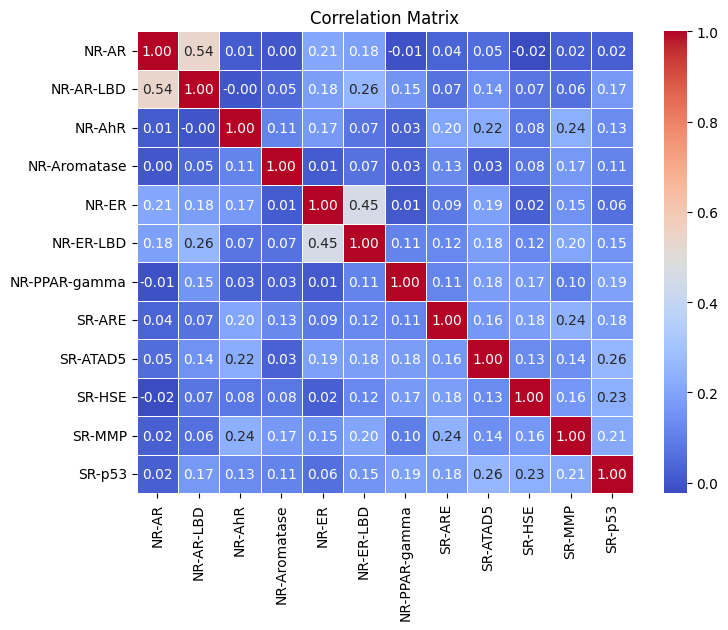

In [78]:
ds1 = ds.drop(['smiles'], axis=1)
correlation = ds1.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [79]:
ds2 = ds.copy()
ds['smiles'] = ds['smiles'].apply(Chem.MolFromSmiles)

[19:10:51] WARNING: not removing hydrogen atom without neighbors


In [81]:
ds2.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,smiles
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCN1C(=O)NC(c2ccccc2)C1=O
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC(O)(P(=O)(O)O)P(=O)(O)O


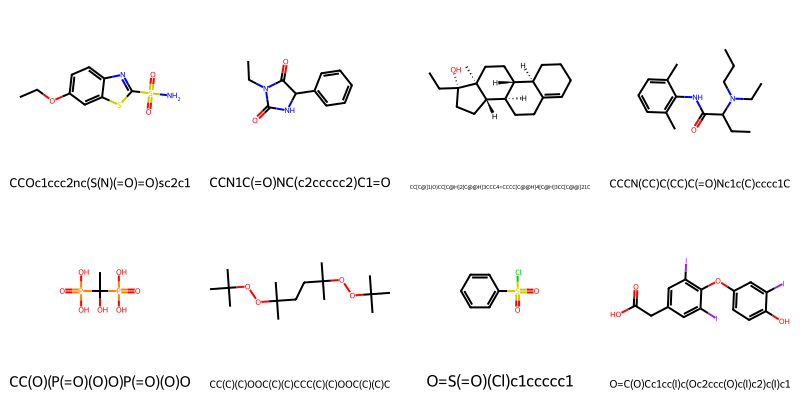

In [85]:
Draw.MolsToGridImage(ds['smiles'][:8],molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ds['smiles'][:8]])

In [42]:
ds.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,<rdkit.Chem.rdchem.Mol object at 0x00000122096...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX3020,<rdkit.Chem.rdchem.Mol object at 0x00000122096...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX3024,<rdkit.Chem.rdchem.Mol object at 0x00000122096...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX3027,<rdkit.Chem.rdchem.Mol object at 0x00000122096...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,<rdkit.Chem.rdchem.Mol object at 0x00000122096...
